# Convolutional Neural Network (CNN)

## Convolution
Imagine that you are rolling two fair dice and the outcome of each roll is a probability distribution:
$$
f(x)=g(y)=
\begin{cases}
\frac{1}{6}, & \text{if }x\in\{1,2,3,4,5,6\} \\
0, & \text{otherwise}
\end{cases}
$$
The distribution $g$ may be different from $f$ if $g$ has certain weights on certain values. Then the probability of rolling 4 in total could be
$$
f(1)g(3) = \frac{1}{36} .
$$
To find the *total likelihood* of two dice summing 4, we have consider all possible values of the two dice, that is, we consider all possible partitions of 4. Thus, the probability of two dice summing 4 is 
$$
f(1)g(3)+f(2)g(2)+f(3)g(1) = \sum_{x+y=4}f(x)g(y) = \frac{1}{12}.
$$
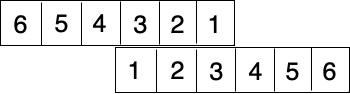

This is exactly a convolution. In general, a convolution evaluated at $c$ is defined as
$$
(f*g)(c)\dot{=}\sum_{x+y=c}f(x)g(y),
$$
or
$$
(f*g)(c)=\sum_x f(x)g(c-x). 
$$
For continuous probability distribution, we replace the sum by a integral over the domain
$$
(f*g)(c)=\int_{\mathbb{R}} f(x)g(c-x) dx.
$$

The convolutional layers in CNN is an application of convolutions for matrices.

**Definition** Let $M\in\mathbb{R}^{n_1\times n_2}$ and $K\in\mathbb{R}^{m_1\times m_2}$ such that $m_1\leq n_1$, $m_2\leq n_2$. $n_1,m_1$ are depths, and $n_2,m_2$ are widths. The **convolution** of $M$ and $K$ is denoted by $Y*K$ with entries
$$
[M*K]_{i,j}=\sum_{k=1}^{m_1}\sum_{l=1}^{m_2} K_{k,l}Y_{i+m_1-k,j+m_2-l}
$$
for $1\leq i\leq n_1-m_1+1$ and $1\leq j\leq n_2-m_2+1$. Here $M$ is called the input and $K$ is called the **kernel** or **feature map** or **activation map**. Typically, the kernel is usually square, say $m\times m$, and it's a hyperparameter of $m^2$ parameters of CNN.

**Example** Suppose we have a data matrix
$$
M=
\left[\begin{matrix}
1 & 5 & -2 & 0 & 2 \\
3 & 8 & 7 & 1 & 0 \\
−1 & 0 & 1 & 2 & 3 \\
4 & 2 & 1 & −1 & 2 \\
\end{matrix}\right].
$$
and a kernel matrix
$$
K=
\left[\begin{matrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \\
\end{matrix}\right].
$$
The definition might look confusing at a glance, but the computation of entries can be roughly said that each element of $M$ is multiplied by the entry of flipped up and down, left and right kernel $K$. 
$$
[M*K]_{1,1}=
\left[\begin{matrix}
1\cdot 9 & 5\cdot 8 & -2\cdot 7 & 0 & 2 \\
3\cdot 6 & 8\cdot 5 & 7\cdot 4 & 1 & 0 \\
−1\cdot 3 & 0\cdot 2 & 1\cdot 1 & 2 & 3 \\
4 & 2 & 1 & −1 & 2 \\
\end{matrix}\right]
=9+40-14+18+40+28-3+0+1=119
$$

### Cross correlation
In PyTorch dicument, you'll see that `nn.Conv2d` performs cross correlation on images instead of convolution. The reason is that **the weights are learned**. Thus, it doesn't matter if it is implemented using cross-correlation since the neural network will learn the mirrorred version of kernel.

Cross correlation is more intuitive:
$$
[M\cdot K]_{1,1}\dot{=}
\left[\begin{matrix}
1\cdot 1 & 5\cdot 2 & -2\cdot 3 & 0 & 2 \\
3\cdot 4 & 8\cdot 5 & 7\cdot 6 & 1 & 0 \\
−1\cdot 7 & 0\cdot 8 & 1\cdot 9 & 2 & 3 \\
4 & 2 & 1 & −1 & 2 \\
\end{matrix}\right].
$$

## Padding and Stride
The convolution operation will reduce the dimension of the input matrix. Sometimes we hope that the dimension is not reduced quickly by convolutions or even retain the original size. We can use **(zero) padding** $p\in\mathbb{N}$ to keep the shape of matrix. For $p=1$, the matrix $M$ becomes
$$
M=
\left[\begin{matrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 5 & -2 & 0 & 2 & 0 \\
0 & 3 & 8 & 7 & 1 & 0 & 0 \\
0 & −1 & 0 & 1 & 2 & 3 & 0 \\
0 & 4 & 2 & 1 & −1 & 2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 
\end{matrix}\right].
$$
We can also set an integer **stride** $s$, or tuple $(s_1,s_2)$, which means how far to move the kernel. Usually, the kernel moves from left to right, top to down, and performs a convolution with the corresponding submatrix. For example, when the stride is 2, the kernel moves as the picture in `CNN/images`. The red matrix indicates the position of the $3\times 3$ kernel  before a stride, and the green one is after a stride.

In general, a stride $s>1$ reduces the dimension of the output of a convolution to
$$
\left(\frac{n_1-m}{s}+1\right)\times\left(\frac{n_2-m}{s}+1\right).
$$
If we have $N$ filters, then there are $N\cdot m^2$ variables and the output size of a convolution is
$$
\left(\frac{n_1+2p-m}{s}+1\right)\times\left(\frac{n_2+2p-m}{s}+1\right)\times N
$$
where the results for all $N$ filters are stacked (we'll show it later). 

Given the $n_1,n_2,m$ and stride $s$. If we want to retain the size of the output by determining padding $p$, we solve the equations:
$$
\begin{aligned}
& \frac{n_1+2p-m}{s}+1=n_1 \\
& \frac{n_2+2p-m}{s}+1=n_2.
\end{aligned}
$$
We need to assume $n_1=n_2$ for otherwise, the solution does not exist. Then 
$$
p=\frac{(n_1-1)\cdot s+m-n_1}{2}=\frac{n_1\cdot(s-1)-s+m}{2}.
$$
If $s=1$ and $n_1=n_2$, then
$$
p=\frac{m-1}{2}.
$$
Typically, you can choose kernel size $m=3$ with stride $s=1$ and padding $p=1$ to retain the size of the output.

**Example** Let $s=2$ and $p=0$. The kernel moves from the red submatrix to the blue submatrix. Since the kernel touches the right edge, it restarts from the leftmost submatrix with 2 grids down (green submatrix).

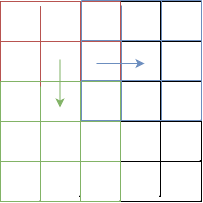

## Detector Layer
The detector layer simlpy apply the activation to a matrix component-wise. For 2-dimensional CNN, the detector layer is
$$
(\sigma(Y))_{i,j}=\sigma(Y_{i,j}).
$$
## Pooling Layer
This layer type is responsible for reducing the first two dimensions (height and width) and usually does not interfere with the third dimension (depth, or channels) of the input $M$ , but rather is **applied for all channels independently**. A pooling kayer has a filter size. For stride $s$ and padding $p$, the output dimsion is reduced to
$$
\left(\frac{n_1+2p-m}{s}+1\right)\times\left(\frac{n_2+2p-m}{s}+1\right). 
$$
Let
$$
M=
\left[
\begin{matrix}
1 & -1 & 7 & 3 \\
2 & 3 & 1 & 2 \\
3 & 1 & 2 & 9 \\
2 & 4 & 8 & -3 
\end{matrix}
\right].
$$
A **max pooling** with kernel size $2\times 2$, stride $s=2$ and padding $p=0$ gives us
$$
\left[
\begin{matrix}
1 & -1 & 7 & 3 \\
2 & 3 & 1 & 2 \\
3 & 1 & 2 & 9 \\
2 & 4 & 8 & -3 
\end{matrix}
\right]
\to
\left[
\begin{matrix}
3 & 7 \\
4 & 9
\end{matrix}
\right].
$$
Also, an **average pooling** outputs
$$
\left[
\begin{matrix}
1.25 & 0.75 \\
2.5 & 4
\end{matrix}
\right].
$$

## CNN Implementation
In this section, we build a CNN and test it with MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [29]:
# Device configuration
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


In [3]:
# Set hyperparameter
config = {
    'n_epoch':4,
    'batch_size':64,
    'lr':0.001,
}

In [4]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),
])

In [5]:
train_set = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
                                
test_set = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
                                       
train_loader = torch.utils.data.DataLoader(train_set, batch_size=config['batch_size'],shuffle=True)
                                          
test_loader = torch.utils.data.DataLoader(test_set, batch_size=config['batch_size'],shuffle=False)                                         

random index: tensor([95])
Before transpose: (1, 28, 28)
After transpose: (28, 28, 1)


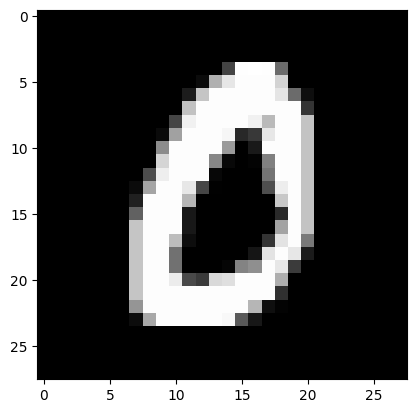

In [19]:
random_index = torch.randint(1000,(1,)) 
print('random index:',random_index)

sample_img,sample_label = train_set[int(random_index)]
sample_img = sample_img.numpy()                  
print('Before transpose:',sample_img.shape) 
sample_img = np.transpose(sample_img,(1,2,0)) 
print('After transpose:',sample_img.shape)    
plt.imshow(sample_img,cmap='gray')        

Let's look into the parameters of `nn.Conv2d` in pytorch.
- `nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`

The definition of kernel_size, stride and padding are the identical to the above.
- `in_channels`: the number of channels of the input to the convolutional layer. For RGB images, `in_channels==3` and for gray images, `in_channels==1`.
- `out_channels`: the number of feature maps, the number of kernels that you apply to the input. The results of all kernels are stacked. 

We apply probably the simpliest CNN architecture LeNet proposed in [Y,L,Y,P]. The model structure is as below:
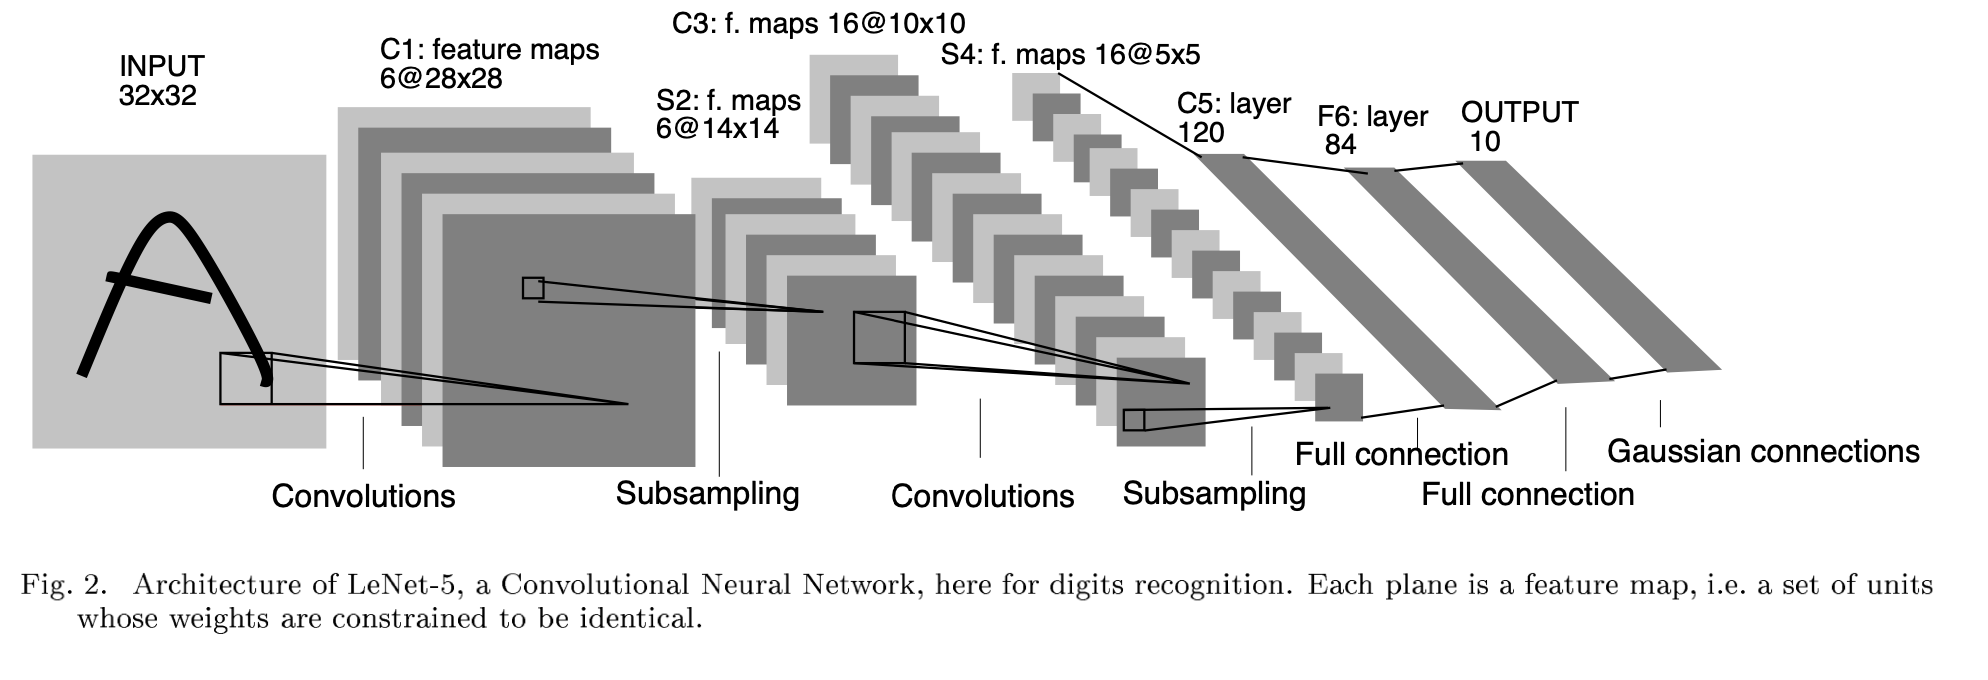
- input to C1: 6 kernels with size 5 and stride 1, padding 0
$$
\frac{n_1+2p-m}{s}+1=\frac{32+0-5}{1}+1=27+1=28.
$$
The output is a [6,28,28] tensor. For MNIST dataset ([28,28,1]), we need padding=2.
- C1 to S2: 6 pooling layer for 6 channels, kernel size 2, stride 2, padding 0
$$
\frac{n_1+2p-m}{s}+1=\frac{28+0-2}{2}+1=13+1=14
$$
The output is a [6,14,14] tensor.
- S2 to C3: `in_channels`= 6, `out_channels`=16 (16 kernels), kernel size 5, stride 1, , padding 0
$$
\frac{n_1+2p-m}{s}+1=\frac{14+0-5}{1}+1=10
$$
The output is a [16,10,10] tensor.
- C3 to S4: 16 pooling layer for 16 channels, kernel size 2, stride 2, padding 0
$$
\frac{n_1+2p-m}{s}+1=\frac{10+0-2}{2}+1=13+1=5
$$
The output is a [16,5,5] tensor.
- S4 to C5: `in_channels`=16, `out_channels`=120, kernel size 5, stride 1, , padding 0
$$
\frac{n_1+2p-m}{s}+1=\frac{5+0-5}{1}+1=1
$$
The output is a [120,1,1] tensor.
- C5 to F6: linear (fully-connected)
- F6 to output: linear (fully-connected)

This is our model. Here we omit the batch size, which is at the 0th dimension, i.e. (28,28,1) should be (batch_size,28,28,1).

In [43]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input size: (28,28,1)
        self.cnn = nn.Sequential(
            nn.Conv2d(1,6,5,1,2), 
            # padding: (32,32,1)
            # after Conv2d: (6,28,28)
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (6,14,14)

            nn.Conv2d(6,16,5,1,0),
            # after Conv2d: (16,10,10)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (16,5,5)
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fully_connected(out)

In [31]:
model = Classifier()
print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


Check network parameters

In [22]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

cnn.0.weight torch.Size([6, 1, 5, 5]) True
cnn.0.bias torch.Size([6]) True
cnn.1.weight torch.Size([6]) True
cnn.1.bias torch.Size([6]) True
cnn.4.weight torch.Size([16, 6, 5, 5]) True
cnn.4.bias torch.Size([16]) True
cnn.5.weight torch.Size([16]) True
cnn.5.bias torch.Size([16]) True
fully_connected.0.weight torch.Size([120, 400]) True
fully_connected.0.bias torch.Size([120]) True
fully_connected.2.weight torch.Size([84, 120]) True
fully_connected.2.bias torch.Size([84]) True
fully_connected.4.weight torch.Size([10, 84]) True
fully_connected.4.bias torch.Size([10]) True


In [44]:
from torchmetrics import Accuracy

def TrainCNN():
    # Pass model to gpu
    model.to(device)

    # Set to train mode
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 
    criterion = nn.CrossEntropyLoss()
    accuracy = Accuracy(task='multiclass',num_classes=10)

    accuracy = accuracy.to(device)

    for epoch in range(config['n_epoch']):
        train_loss, train_acc = 0.0, 0.0
        
        for batch in train_loader:
            # Seperate images and lables
            imgs, labels = batch

            # Forward the images
            # Make sure your images are passed to gpu
            pred = model(imgs.to(device))

            loss = criterion(pred, labels.to(device))
            train_loss += loss.item()

            acc = accuracy(pred, labels.to(device))
            train_acc += acc

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}")

        

In [45]:
TrainCNN()

Epoch: 0| Train loss:  0.03361| Train acc:  0.98984
Epoch: 1| Train loss:  0.03013| Train acc:  0.99069
Epoch: 2| Train loss:  0.02512| Train acc:  0.99245
Epoch: 3| Train loss:  0.02122| Train acc:  0.99317


- `torch.unsqueeze(input, dim)`: returns a new tensor with a dimension of size one inserted at the specified position.

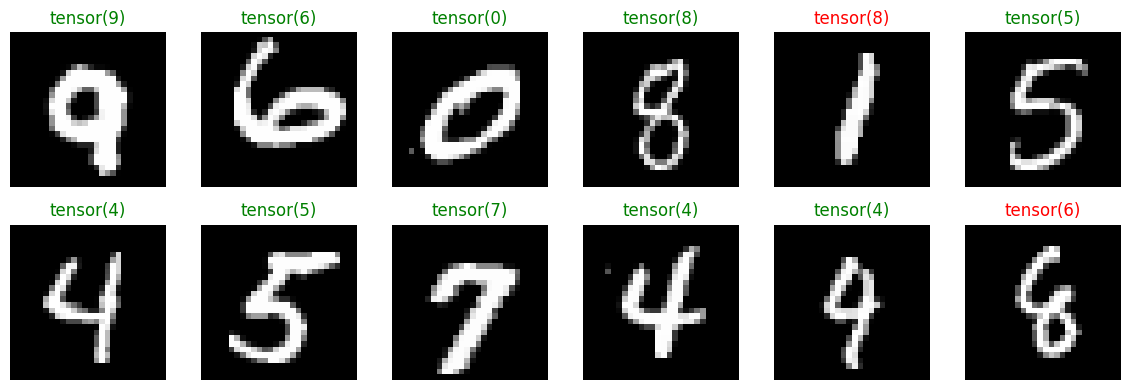

In [53]:
# %matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_set), size=(1,)).item()
    img, label = test_set[random_idx]
    
    # print('img shape:',img.shape)
    # print('unsqueezed img shape:',img.unsqueeze(dim=0).shape)
    img_temp = img.unsqueeze(dim=0).to(device)
    label_pred = torch.argmax(model(img_temp))
    # print(label_pred)
    fig.add_subplot(rows, cols, i)

    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img, cmap='gray')
    if label_pred == label:
        plt.title(label_pred, color='g') # for correct prediction
    else:
        plt.title(label_pred, color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout()

## Deconvolution
PyTorch also provides transposed convolution module over an input image, called `ConvTranposed2D`, though it's **not actual deconvolution operation since it's not a true inverse of convolution**. It's usually used for upsampling of the input and representing low-dimensional images to high-dimensional images. The page [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) gives a good visualization.

The parameters of `nn.ConvTransposed2D` are identical to `nn.Conv2D`, but the shape of $H_{out}$ and $W_{out}$ are reversed, given by
$$
H_{out}=(H_{in}-1)*\text{stride}[0]-2*\text{padding}[0]+(\text{kernel size}[0]-1)+1
$$
and 
$$
W_{out}=(W_{in}-1)*\text{stride}[1]-2*\text{padding}[1]+(\text{kernel size}[1]-1)+1
$$
if using the default values of `output_padding`, `groups`, and `dilation`. 

The formula looks terrible, but it's actually very easy: **It recovers the shape of the output of a convolution**.

## Implementation 
Please refer to the DCGAN in 11_GAN.

## References
- [Herberg] [Lecture Notes: Neural Network Architectures](https://arxiv.org/abs/2304.05133), arxiv
- [Vincent Dumoulin, Francesco Visin] [A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285v1.pdf), arxiv
- [Y. Lecun, L. Bottou; Y. Bengio; P. Haffner] [Gradient Based Learning Applied to Do cument Recognition](https://ieeexplore.ieee.org/document/726791), ieee
- [Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton] [ImageNet Classification with Deep Convolutional Neural Networks](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjbsNfYqquBAxVWIYgKHaBNC8AQFnoECA4QAQ&url=https%3A%2F%2Fproceedings.neurips.cc%2Fpaper%2F4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf&usg=AOvVaw26V5YkBm0FS972qI4eBNgu&opi=89978449), NIPS
- [Performing Convolution (NOT cross-correlation) in pytorch](https://stackoverflow.com/questions/42970009/performing-convolution-not-cross-correlation-in-pytorch), stackoverflow
- [What is a channel in a CNN?](https://datascience.stackexchange.com/questions/64278/what-is-a-channel-in-a-cnn), datascience.stackexchange
- [LeNet-5 Implementation on MNIST in PyTorch](https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37), medium